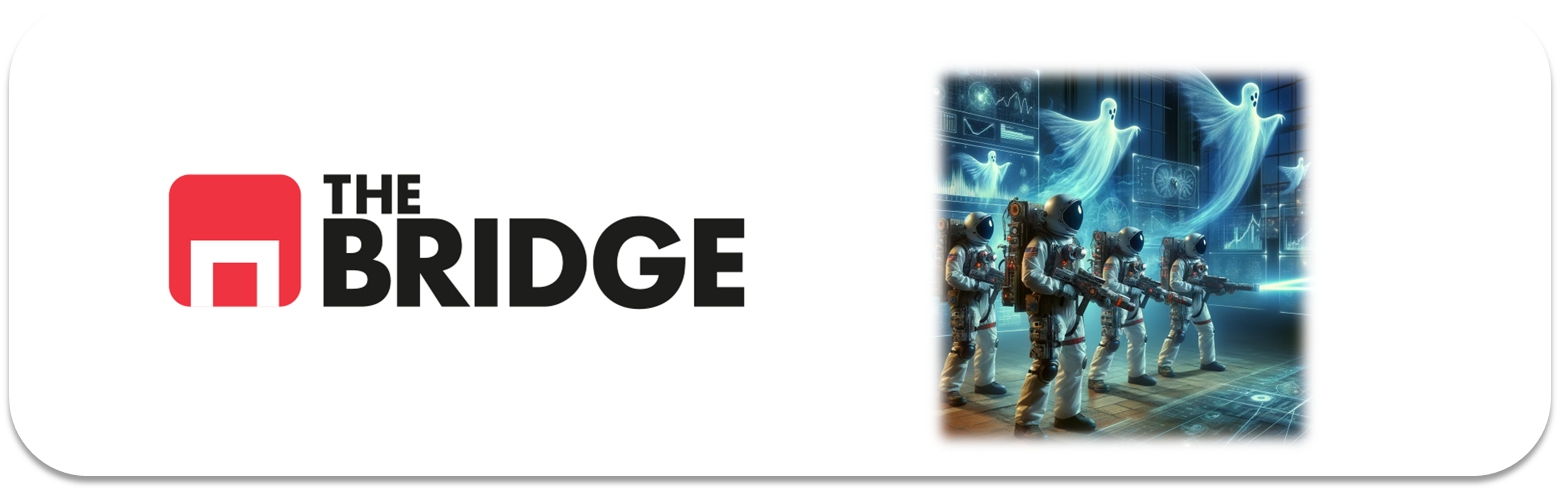

*Adaptado de: "Hands-on Machine Learning with Scikit-Learn..." de Aurelien Geron

## APLICACIONES ML (I): SERIES TEMPORALES

### Inicialización y datos

Empezamos cargando nuestras librerías y en este caso, adelantándonos a la exposición de nuestro problema de negocio, también vamos a cargar el dataset que nos han proporcionado desde la central de operaciones. El dataset recoge datos de transporte de pasajeros en Chicago desde 2001 tanto en tren (el tranvía y suburbano) como en autobús, hasta finales de noviembre de 2021.

In [1]:
# %pip install pmdarima

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:
df = pd.read_csv("./data/chicago_transport.csv", sep = "|")

Si te fijas, observarás unos cuantos recien llegados a nuestra hermandad más o menos extensa de liberías y módulos para DataScience de Python.

### Introducción a las series temporales: Predicción de pasajeros


¡Muy bien! Vamos a suponer que acabas de ser contratado como científico de datos por la Autoridad de Tránsito de Chicago. Tu primera tarea es construir
un modelo capaz de predecir el número de pasajeros que viajarán en autobús y tren al día siguiente. Tienes acceso
a los datos de pasajeros diarios desde 2001. Vamos a ver juntos cómo manejarías esto. Comenzaremos echando un vistazo y
limpiando los datos:


Establecemos nombres cortos para las columnas, ordenamos las filas por fecha, eliminamos la columna total redundante y eliminamos las filas duplicadas.

In [4]:
# 4 shorter names
df.columns = ["date", "day_type", "bus", "rail", "total"] 

df["date"] = pd.to_datetime(df["date"])

# La fecha como índice, que si recuerdas de tiempos antiguos, nos ayudará en Pandas.
df = df.sort_values("date").set_index("date") 

# no need for total, it's just bus + rail
df = df.drop("total", axis=1) 

# 4 remove duplicated months (2011-10 and 2014-07)
df = df.drop_duplicates() 


Ahora veamos qué nos dicen las primeras filas:

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


El 1 de enero de 2001, 297.192 personas abordaron viajaron en autobús en Chicago, y 126.455 lo hicieron en cualquier modalidad de tren urbano (el tren elevado, el metro, etc). La columna day_type contiene W para los días de semana, A para los sábados y U para los domingos o días festivos.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7639 entries, 2001-01-01 to 2021-11-30
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   day_type  7639 non-null   object
 1   bus       7639 non-null   int64 
 2   rail      7639 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 238.7+ KB


Veamos los primeros meses de 2019 (ten en cuenta que Pandas trata los límites del rango como inclusivos):

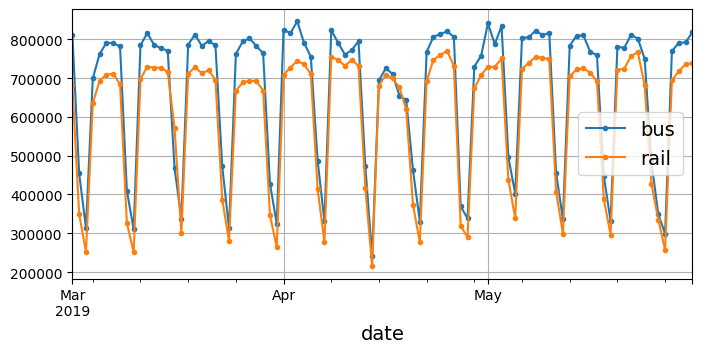

In [7]:
# Los límites en las fechas son inclusivos
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Esto es una serie temporal: datos con valores en diferentes intervalos de tiempo, generalmente a intervalos regulares. Más específicamente, dado que hay múltiples valores por intervalos de tiempo, esto se llama una serie temporal **multivariada**. Si solo observáramos la columna de autobús, sería una serie temporal **univariada**, con un único valor por intervalo de tiempo. Predecir valores futuros (es decir, pronosticar) es la tarea más típica al tratar con series temporales, y en esto nos enfocaremos en este capítulo. Otras tareas incluyen imputación (rellenar valores pasados faltantes), clasificación, detección de anomalías, y más.

Mirando la figura, podemos ver que un patrón similar se repite claramente todas las semanas. Esto se llama **estacionalidad semanal**. De hecho, es tan fuerte en este caso que pronosticar el número de pasajeros de mañana copiando simplemente los valores de una semana antes dará resultados razonablemente buenos. Esto se llama ***predictor ingenuo (naive predictor)***: simplemente copiar un valor pasado para hacer nuestro pronóstico.

El predictor ingenuo es a menudo es una gran referencia o baseline, e incluso puede ser difícil superarlo en algunos casos [como veremos].

Para visualizar como serían las predicciones de nuestro "naive predictor", vamos a superponer las dos series temporales (para autobús y tren), así como las mismas series temporales retrasadas por una semana (es decir, desplazadas hacia la derecha) utilizando líneas punteadas. También pintaremos la diferencia entre ambas (es decir, el valor en el tiempo t menos el valor en el tiempo t-7) (a este proceso de restar a un valor en el tiempo otro n intervalos de tiempo anterior se le conoce como **diferenciación** o **diferenciar** y es esencial en el tratamiento de series temporales como vas a comprobar en breve). Veamos esas gráficas:

In [8]:
comienzo = "2019-03"
fin = "2019-05"

# Diferenciamos
diff_7 = df[["bus", "rail"]].diff(7)[comienzo:fin] 

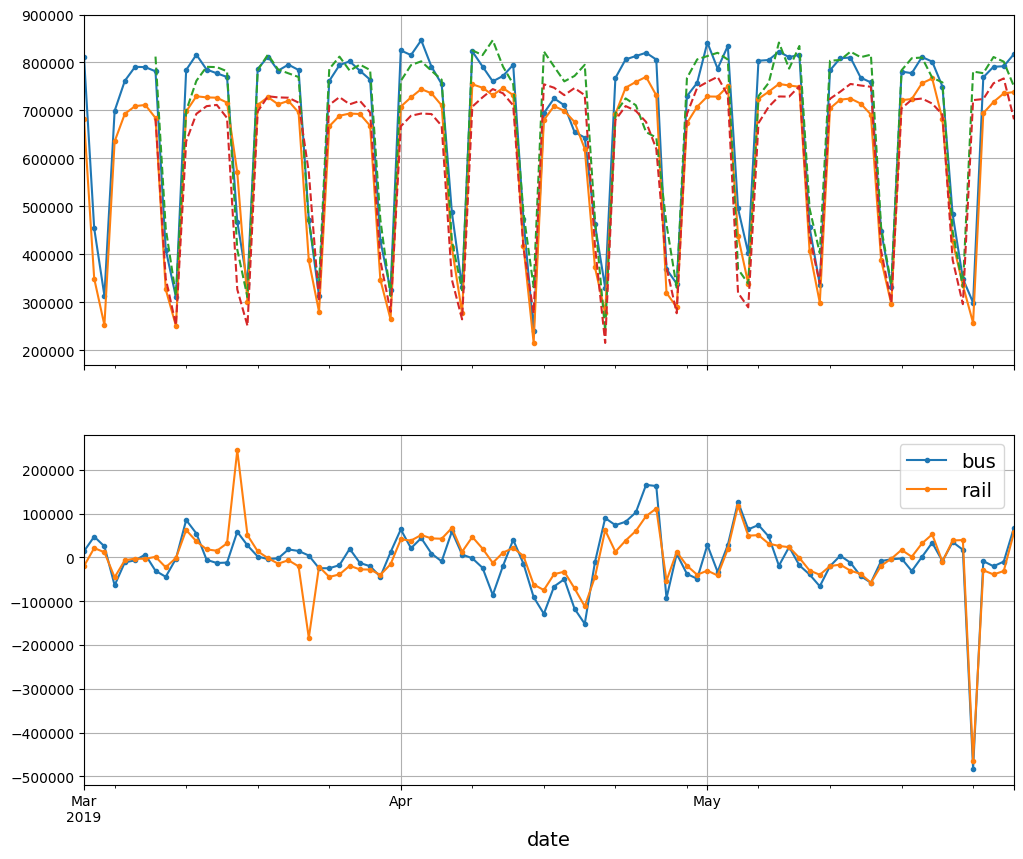

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
df[comienzo:fin].plot(ax=axs[0], legend=False, marker=".")  # original time series
df[comienzo:fin].shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle="--")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000]) 
plt.show()

Observa lo bien que las series temporales retrasadas se superponen o siguen la serie temporal real. Cuando una serie temporal está correlacionada con una versión retrasada de sí misma, decimos que la serie temporal está autocorrelacionada. Como puedes ver, la mayoría de las diferencias son bastante pequeñas, excepto a finales de mayo. ¿Quizás hubo un día festivo en ese momento? Vamos a verificar la columna day_type:'

In [10]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

De hecho, hubo un largo fin de semana en ese entonces: el lunes fue lo que en USA se conoce como el Memorial Day (festivo en USA en el que se recuerda la memoria de los caídos en combate) y lo celebran el último lunes de mayo. Podríamos usar esta columna (tipo de día) para mejorar nuestras previsiones, pero por ahora solo midamos el error absoluto medio en el período de tres meses en el que nos estamos enfocando arbitrariamente—marzo, abril y mayo de 2019—para tener una idea aproximada de cómo es nuestro predictor "naive", por cierto que estamos hablando de predicir valores numéricos por tanto de un problema de regresión y por eso usaremos el MAE (para empezar, podríamos emplear cualquier métrica de regresión):

In [11]:
# Sobre las diferencias que básicamente son el error...
diff_7.abs().mean() 

bus     43915.608696
rail    42143.271739
dtype: float64

Nuestras previsiones ingenuas tienen un MAE de alrededor de 43.916 pasajeros de autobús, y alrededor de 42.143 pasajeros de tren. Es difícil saber a simple vista si esto es bueno o malo por el hecho de que son dos series temporales con rangos de valores diferentes. Recuerda que para comparar el error en series puede resultar más útil el usar el MAPE:

In [12]:
targets = df[["bus", "rail"]]["2019-03":"2019-06"]
((diff_7 / targets).abs().mean())*100

bus     8.293847
rail    8.994765
dtype: float64

Nuestro predictor "naive" obtiene un MAPE de aproximadamente 8.3% para el autobús y 9.0% para el ferrocarril. Es interesante notar que el MAE para las predicciones de ferrocarril parece ligeramente mejor que el MAE para las predicciones de autobús, mientras que lo contrario es cierto para el MAPE. Eso se debe a que el número de pasajeros en autobús es mayor que el número de pasajeros en ferrocarril, por lo que naturalmente los errores de predicción también son mayores, pero cuando ponemos los errores en perspectiva, resulta que las predicciones de autobús en realidad son ligeramente mejores que las predicciones de ferrocarril.

***

Antes de entrar en cómo obtener otros modelos más sofisticados que el ingenuo, sigamos explorando algunos conceptos interesantes. Por ejemplo veamos si existen otros tipos de estacionalidad en las series.

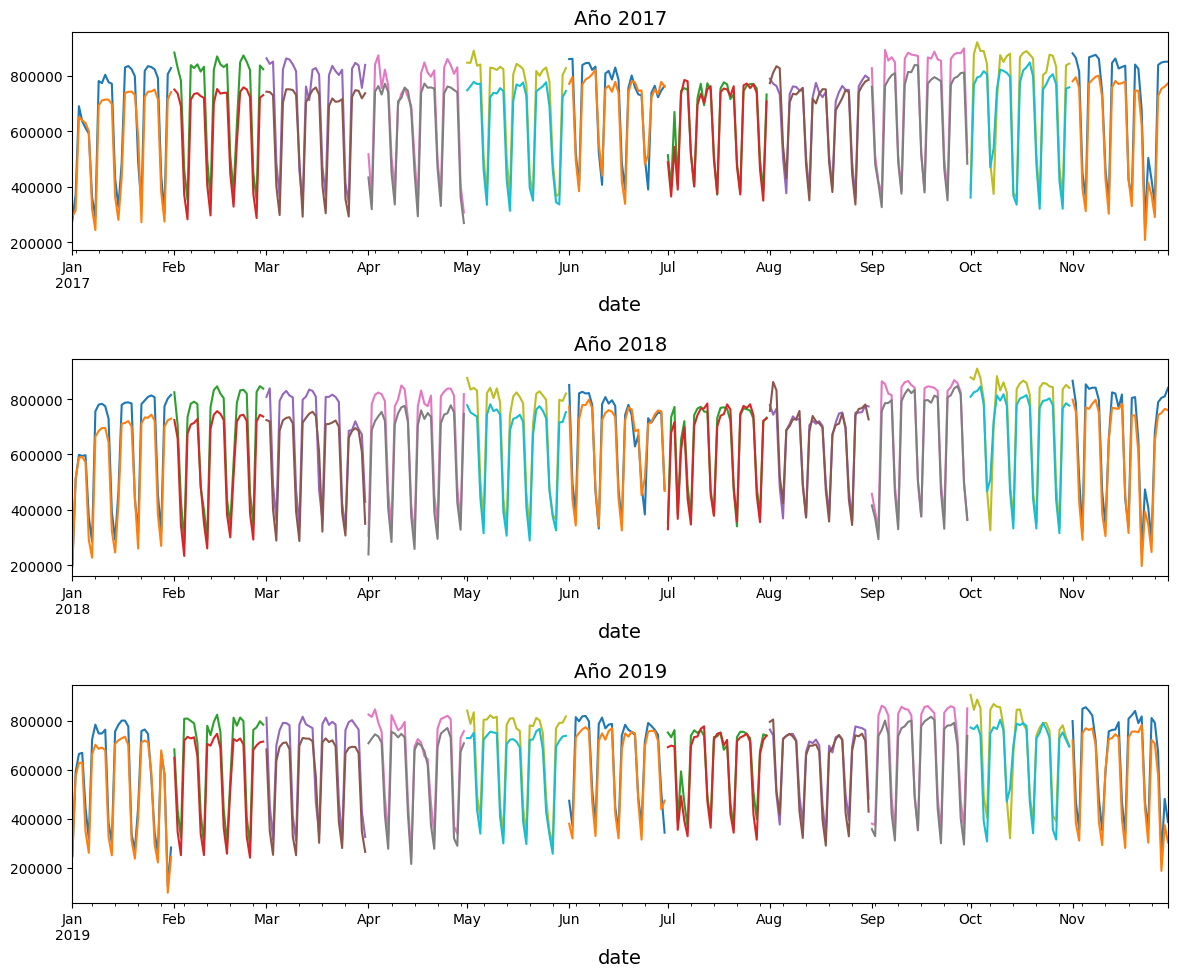

In [13]:
# Estacionalidad mensual, pintamos los meses superpuestos del periodo 2017-2019:
fig, axes = plt.subplots(len(range(2017,2020)),1, figsize = (12, 10))
for indice, year in enumerate(range(2017,2020)):
    for month in range(1,12):
        df[f"{year}-{month:02}":f"{year}-{month:02}"].plot(ax= axes[indice], legend = False)
        axes[indice].set_title(f"Año {year}")
plt.tight_layout();

No parece haber ninguna **estacionalidad mensual** significativa, pero verifiquemos si hay alguna estacionalidad anual. Observaremos los datos desde 2001 hasta 2019. Para reducir el riesgo de observaciones engañosas de datos (vamos, para no ver los que luego usaremos como test), ignoraremos los datos más recientes por ahora. También pintaremos un promedio móvil de 12 meses para cada serie para visualizar tendencias a largo plazo:

In [14]:
period = slice("2001", "2019")

# Para mostrar año a año lo vamos a hacer con las medias mensuales, esta es la forma en que pandas permite hacerlo cuando tienes un indice que es tipo DateTime
df_monthly = df[["bus","rail"]].resample('M').mean()  

rolling_average_12_months = df_monthly[period].rolling(window=12).mean()


In [15]:
df_monthly

,bus,rail
date,,
2001-01-31,807190.580645,474591.419355
2001-02-28,848889.000000,488188.178571
2001-03-31,865392.419355,498825.096774
2001-04-30,835126.366667,490444.533333
2001-05-31,862701.419355,507862.258065
...,...,...
2021-07-31,342101.096774,257660.193548
2021-08-31,353215.516129,260038.548387
2021-09-30,401958.833333,299608.366667


In [16]:
# Esto es solo para checkear que es el mismo resultado
df["2001-01":"2001-01"][["bus","rail"]].mean()

bus     807190.580645
rail    474591.419355
dtype: float64

In [ ]:
rolling_average_12_months["2001-01":"2002-12"]

,bus,rail
date,,
2001-01-31,NaN,NaN
2001-02-28,NaN,NaN
2001-03-31,NaN,NaN
2001-04-30,NaN,NaN
2001-05-31,NaN,NaN
2001-06-30,NaN,NaN
2001-07-31,NaN,NaN
2001-08-31,NaN,NaN
2001-09-30,NaN,NaN


In [18]:
df_monthly["2001-01": "2001-12"][["bus","rail"]].mean()

bus     826859.753136
rail    497733.685042
dtype: float64

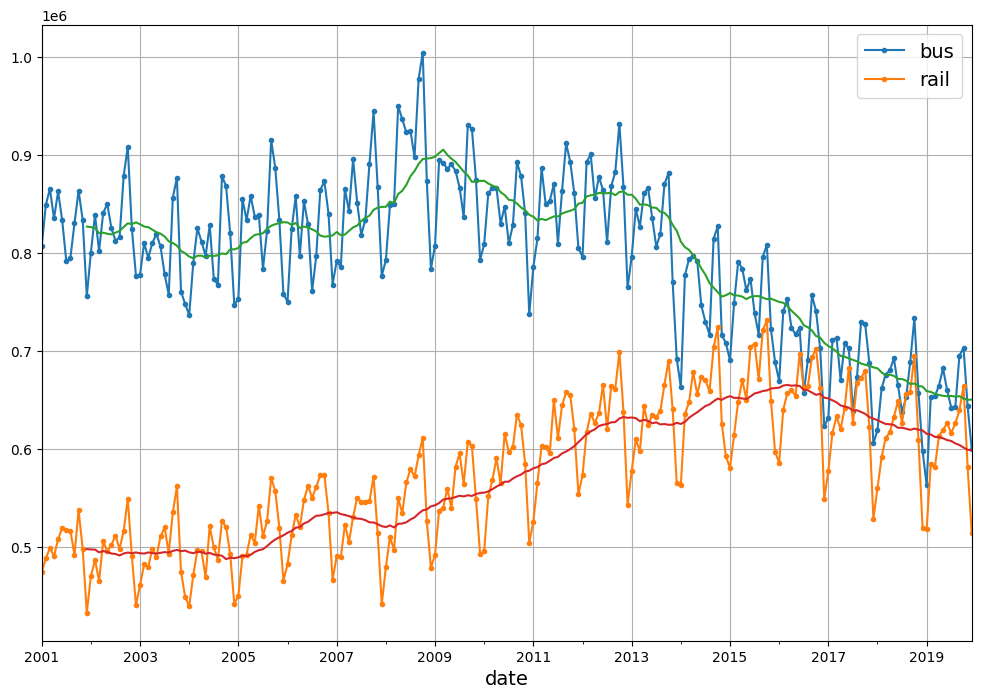

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
# extra code – saves the figure for the book
plt.show()

¡Sí! Definitivamente hay una **estacionalidad anual** también, aunque es más ruidosa (no es tan "perfecta" la repetición) que la estacionalidad semanal, y más visible para la serie de trenes que para la serie de autobuses: vemos picos y valles aproximadamente en las mismas fechas cada año.

Otro aspecto para destacar es esa ventana móvil que nos permite ver lo que se denomina tendencia o **trend** que es otra de las componentes importantes de una serie temporal. Fíjate cómo los valores medios siguen una curva que no es plana con el tiempo, tienen tendencias.

Volviendo a nuestra estacionalidad anual, veamos qué obtenemos si pintamos la diferencia de 12 meses y si podríamos tener un predictor anual naive:

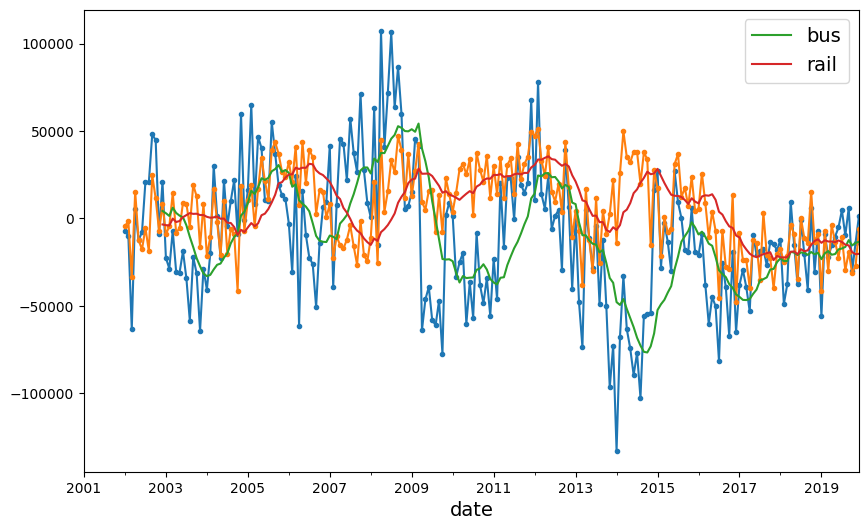

In [20]:
fig, axs= plt.subplots(1,1)
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(10, 6), ax=axs, legend=None)

# Tendencia sobre la serie diferenciada 
df_monthly.diff(12)[period].rolling(window= 12).mean().plot(ax = axs)
plt.show()

No está mal. Pero no es tan "bonito" como el diario basado en la semana anterior. Veamos otro punto importante, si nos quedásemos con el resultado de esa diferenciación mensual (quitar lo que ocurrió el mismo mes del año pasado en este caso, 12 periodos anteriores), fíjate que las series se han "aplanado" (ojo son las lineas azul y naranja), y que ya no existe ese "periodo" o "patrón" anual (hemos extraído o eliminado la componente de estacionalidad anual).

Pero también fíjate en que las tendencias (las líneas verde y roja) ahora ya oscilan entorno al cero no son claramente ascendentes o descendentes. Por ejemplo, la tendencia lineal descendente presente en la serie temporal de 2016 a 2019 se convirtió en un valor negativo aproximadamente constante en la serie temporal diferenciada.

La diferenciación se emplea para eliminar estacionalidad y tendencia para convertir las series en estacionarias. [Eihn mande, que dice calma, haya calma lo explicaremos en un momento, porque es un concepto importante para poder aplicar modelos más complejos y potentes que un predictor ingenuo o naive]

Antes recordemos los conceptos nuevos que hemos aprendido y veamos formas más directas de obtener la tendencia y la estacionalidad de una serie, sin recurrir al análisis visual.

### Tendencia, Estacionalidad y Estacionariedad (Trend, seasonality and stationarity)

Recordemos algunos términos que vimos en la sesión anterior:

* **Serie temporal univariante**: Nuestros pasajeros de autobús o de tren.
* **Serie temporal multivariante**: Considerar conjuntamente los pasajeros tanto de bús como de tren
* **Tendencia**: La variación de la media mensual a lo largo del tiempo.
* **Estacionalidad**: Fluctuaciones regulares o ciclos semanales y anuales en las series que hemos visto.


Aquí tienes una definición sencilla para cada uno de los conceptos relacionados con las series temporales:

1. **Serie Univariante**: Una serie temporal univariante consiste en una secuencia de mediciones de una sola variable recogida a lo largo del tiempo. Por ejemplo, la temperatura diaria registrada en un lugar específico durante un año forma una serie temporal univariante.

2. **Serie Multivariante**: Una serie temporal multivariante involucra mediciones de dos o más variables recogidas en los mismos puntos de tiempo. Por ejemplo, registrar tanto la temperatura como la humedad diaria en un lugar específico durante un año resulta en una serie temporal multivariante.

3. **Tendencia**: La tendencia en una serie temporal se refiere a la dirección general en la que se mueven los datos a lo largo del tiempo. Puede ser ascendente, descendente o constante. La tendencia indica un aumento o disminución sostenida en los valores de la serie temporal.

4. **Estacionalidad**: La estacionalidad se refiere a las fluctuaciones regulares y predecibles en una serie temporal que ocurren en ciclos específicos, como diarios, semanales, mensuales o anuales. Por ejemplo, un aumento en las ventas de helado durante los meses de verano cada año muestra estacionalidad.

5. **Estacionariedad**: Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, son constantes a lo largo del tiempo. Esto significa que la serie no muestra tendencia o variaciones estacionales a lo largo del tiempo, lo que facilita su modelado y predicción.

Recordemos también que nuestro objetivo con las series temporales será predecir los valores futuros de la mismas y que habíamos construido un predictor muy sencillo.

Pues bien, la idea es enseñarte unos modelos más potentes pero estos (salvo uno) dependen de que las series que se les den como input cumplan con una propiedad que se llama **estacionariedad**, es decir que sean estacionarias (**stationary**) en inglés.

$$*$$

NO confundir con la estacionalidad que se parecen mucho en como están escritas pero no son lo mismo.

**Estacionariedad**: Una serie temporal es estacionaria si sus propiedades estadísticas, como la media y la varianza, son constantes a lo largo del tiempo. Esto significa que la serie no muestra tendencia o variaciones estacionales a lo largo del tiempo, lo que facilita su modelado y predicción.

$$*$$

Por eso en el miniEDA de la construcción de un modelo de series temporales tendremos que comprobar si la serie o series que estamos manejando son estacionarias. 

$$*$$

### Comprobación de Estacionariedad, método 1: Extrayendo tendencia y estacionalidad

Este método consiste en descomponer una serie en cuatro componentes:

* Tendencia (T)  
* Estacionalidad (S)
* Cicliclo (c)
* Residual (e)

$$*$$

La función `seasonal_decompose` de la biblioteca `statsmodels` en Python se utiliza para descomponer una serie temporal en sus componentes principales. Los cuatro componentes principales que esta función permite extraer son:

1. **Tendencia**: Este componente refleja la dirección general o el movimiento a largo plazo en los datos a lo largo del tiempo. La tendencia muestra si los datos están aumentando, disminuyendo o manteniéndose relativamente constantes a lo largo de un período prolongado.

2. **Estacionalidad**: Este componente captura las fluctuaciones regulares y periódicas en los datos que ocurren en ciclos fijos, como diario, mensual, trimestral o anual. La estacionalidad se refiere a patrones que se repiten a intervalos regulares debido a factores estacionales.

3. **Cíclico**: A diferencia de la estacionalidad, los componentes cíclicos no tienen una periodicidad fija y pueden variar en duración. Estos ciclos están asociados a fluctuaciones económicas, como los ciclos económicos que pueden durar varios años. Es importante notar que, en algunas implementaciones de `seasonal_decompose`, el componente cíclico puede no distinguirse claramente del componente de tendencia, especialmente en descomposiciones aditivas o en series temporales con ciclos no bien definidos.

4. **Residual**: Este componente contiene la variabilidad en los datos que no puede ser explicada por los componentes de tendencia, estacionalidad o cíclicos. Esencialmente, incluye el ruido o las irregularidades en los datos, así como cualquier patrón no capturado por los otros tres componentes.

Lo importante para el caso de las estacionariedad es ver la tendencia y la estacionalidad]

La descomposición de una serie temporal en estos componentes puede realizarse de manera aditiva o multiplicativa, dependiendo de la naturaleza de la serie temporal:

**Un modelo aditivo**: Y(t) = T(t) + S(t) + c(t) + e(t)

**Un modelo multiplicativo**: Y(t) = T(t) * S(t) * c(t) * e(t)

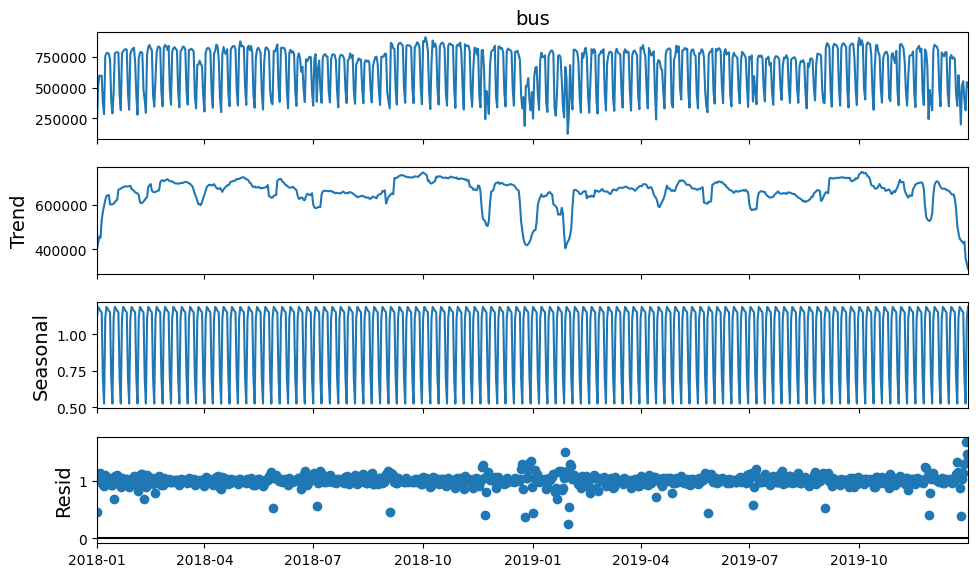

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df["2018":"2019"]['bus'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df["2018":"2019"]['bus'], model='additive', extrapolate_trend='freq')

# Plot del multiplicativo
plt.rcParams.update({'figure.figsize': (10,6)})
result_mul.plot();

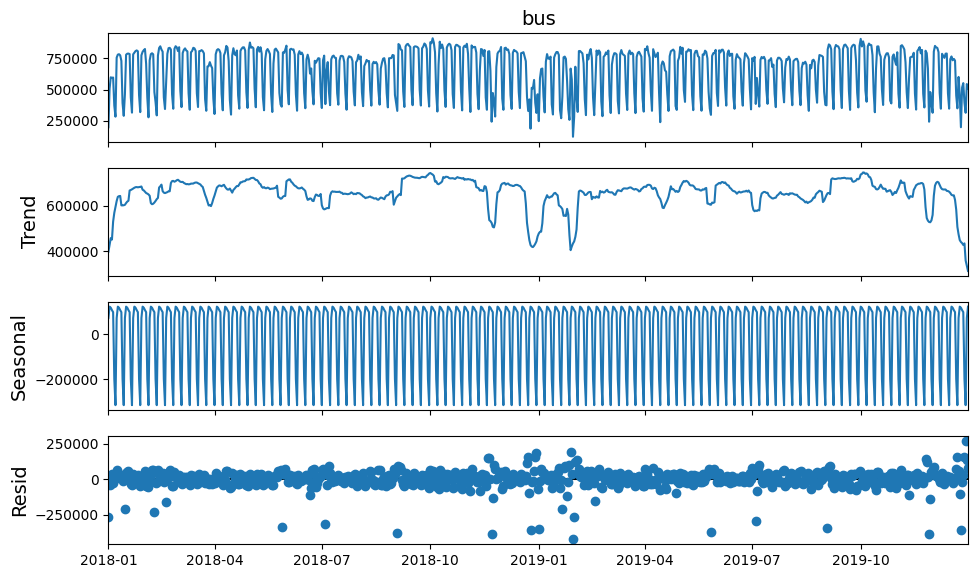

In [22]:
# Plot del aditivo
result_add.plot();

En este caso son prácticamente iguales, en otros contextos tendremos que probar para ver cuál nos conviene más.

¿Cómo se interpreta? Fácil, existe tendencia y/o estacionalidad claras? Sí, como es el caso, entonces NO es ESTACIONARIA. Tendremos que tenerlo en cuenta.

NOTA: En el método seasonal_decompose la parte cíclica se termina absorviendo por el resto de componentes y no se ofrece. No le des más importancia por ahora. Será algo que como ciclo que es tendrás que añadir tú desde fuera.

### Comprobación de Estacionariedad, método 2: Test de hipótesis (test de Dickey-Fuller Aumenatdo o ADFuller)

Pues sí, tenemos un test de hipótesis para comprobar la estacionariedad. En este test la hipótesis nula supone que la serie NO es estacionaria. Si el resultado del test queda por debajo del nivel de significación (0.05), rechazaremos la hipótesis nula en favor de la alternativa. La serie será estacionaria. Es decir nos tiene que salir por debajo del p-value buscado para poder afirmar la estacionariedad:

In [23]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['bus'].values)
result[1]

0.12849516827640678

Como ya esperábamos no podemos rechazar la hipótesis nula de NO estacionariedad (es que no lo es, tiene un componentazo de estacionalidad semanal).

In [24]:

result = adfuller(df['rail'].values)
result[1]

0.10230009412706914

Para el tren pasa igual. Pero veamos que pasa con la serie temporal si la diferenciamos en 7 días (restamos a cada valor el de hace siete días, sí, eso hace que los siete primeros valores sean nulos al no haber siete días antes):

In [25]:

result = adfuller(df['rail'].diff(7)["2017":"2019"].values)
result[1]

2.368899077656009e-17

La serie diferenciada si es ESTACIONARIA (por eso querremos diferenciar). 

Cuando tengamos una serie que no sea estacionaria lo que haremos será algo parecido: diferenciar para quitar la parte de tendencia y la parte estacional. Trabajar con la serie "limpia" y luego a las predicciones añadirles las componentes que se han quitado. Pero calma, aunque ahora vamos a ver cómo hacer esa "limpieza", los modelos que vamos a usar la harán por ti, o por lo menos lo intentarán :-).

***

### Eliminación de tendencias y desestacionalización (Detrending and Deseasonalize)

### Eliminación de tendencias

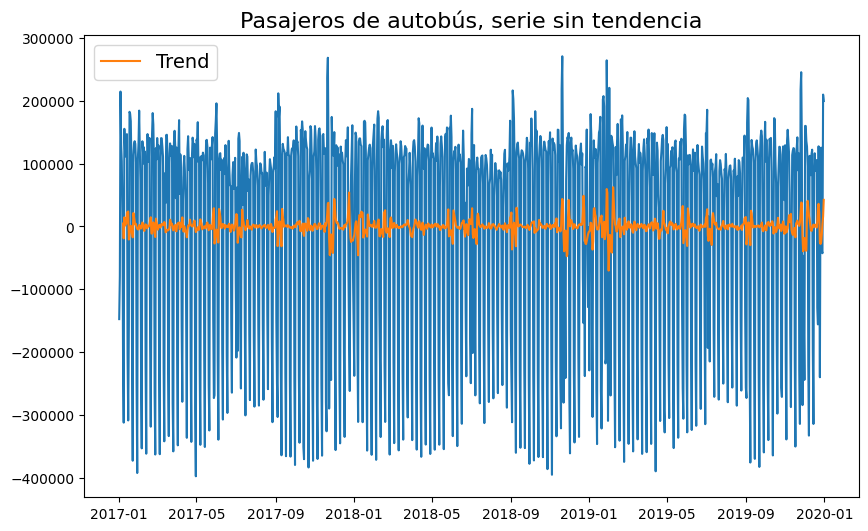

In [26]:
# Quitando la componente de tendencia
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df["2017":"2019"]['bus'], model='aditive', extrapolate_trend='freq')
detrended = df["2017":"2019"]["bus"].values - result_add.trend
plt.plot(detrended)
plt.plot(detrended.rolling(7).mean(), label = "Trend")
plt.legend()
plt.title('Pasajeros de autobús, serie sin tendencia', fontsize=16);

La eliminación de la tendencia tiene residuos, y por eso no es exactamente cero.

3.771442715534193e-18


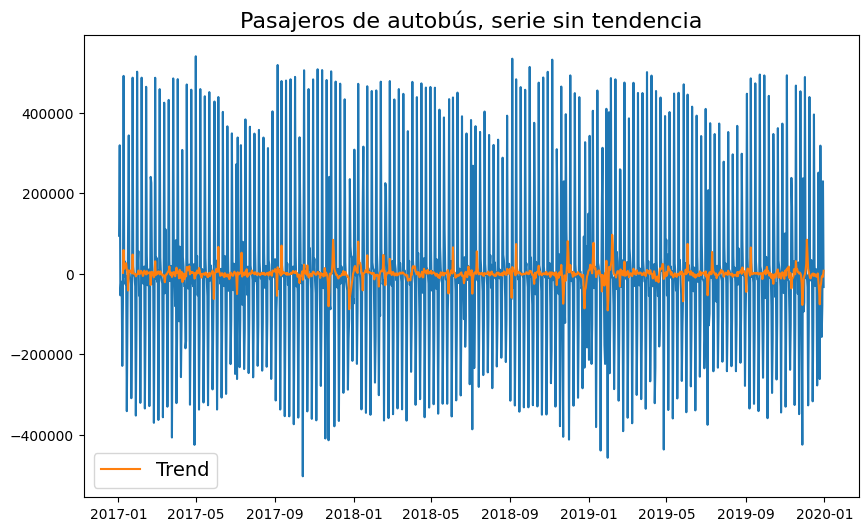

In [27]:
# Using differentiation

plt.plot(df["2017":"2019"].bus.diff())
plt.plot(df["2017":"2019"].bus.diff().rolling(7).mean(), label = "Trend")
plt.legend()
print(adfuller(df["2017":"2019"].bus.diff().dropna().values)[1])
plt.title('Pasajeros de autobús, serie sin tendencia', fontsize=16);

### Desestacionalizar (Deseasonalize)

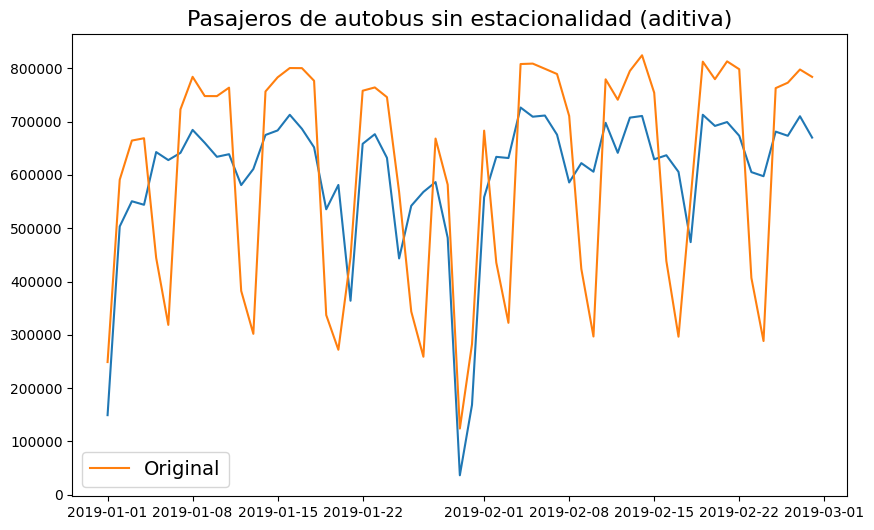

In [28]:
# Time Series Decomposition
result_add = seasonal_decompose(df["2019-01":"2019-02"]['bus'], model='additive', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df["2019-01":"2019-02"].bus.values - result_add.seasonal

# Plot
plt.plot(deseasonalized)
plt.plot(df["2019-01":"2019-02"]["bus"], label = "Original")
plt.legend()
plt.title('Pasajeros de autobus sin estacionalidad (aditiva)', fontsize=16);

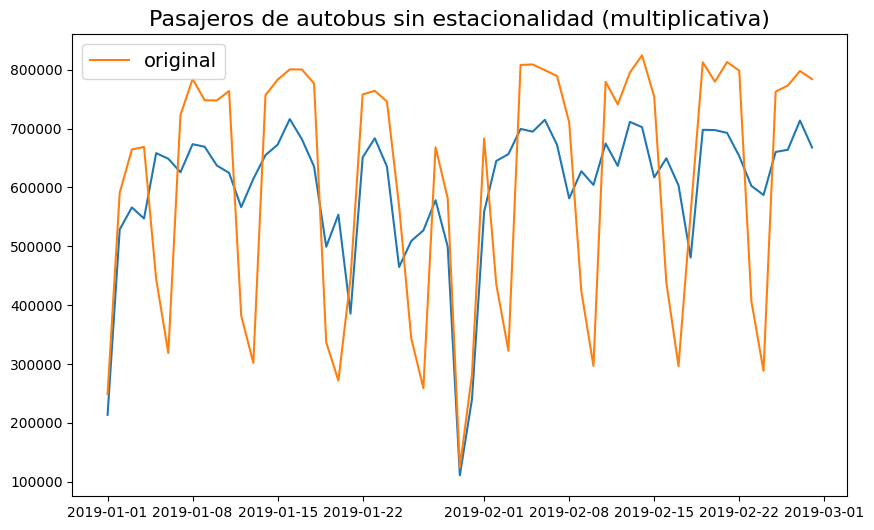

In [29]:
# Time Series Decomposition
result_mul = seasonal_decompose(df["2019-01":"2019-02"]['bus'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df["2019-01":"2019-02"].bus.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.plot(df["2019-01":"2019-02"]["bus"], label = "original")
plt.legend()
plt.title('Pasajeros de autobus sin estacionalidad (multiplicativa)', fontsize=16);

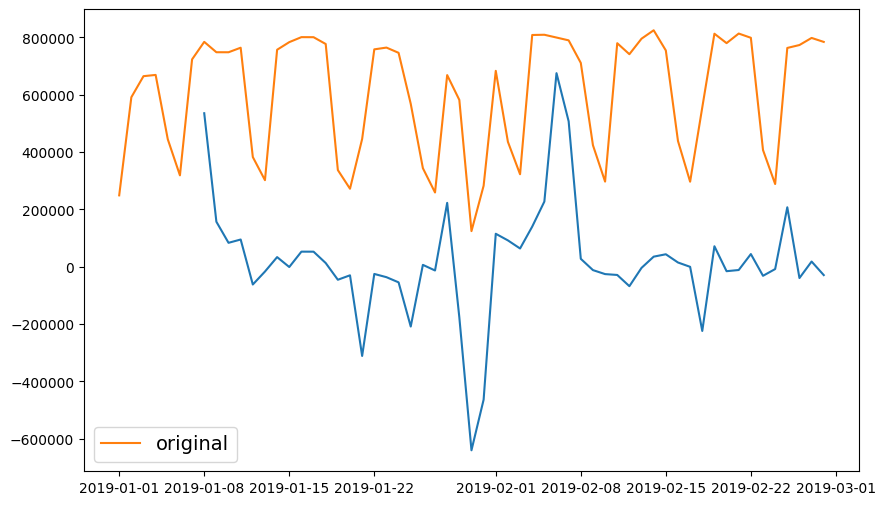

In [30]:
### Quitando la estacionalidad diferenciando por el periodo de estacionalidad más 
# marcado (que este caso es el semanal): (Que además se carga la tendencia también)

plt.plot(df["2019-01":"2019-02"]["bus"].diff(7))
plt.plot(df["2019-01":"2019-02"]["bus"], label="original")
plt.legend()

Lo normal sería ver si una serie es ESTACIONARIA o NO. Si es estacionaria aplicamos los modelos que veremos en las sesiones posteriores tal cual, pero si no lo es, tendremos varias alternativas (quitar tendencia y estacionalidad como hemos visto por componentes o diferenciando) o directamente pidéndole al modelo que lo haga (esto nos soluciona el tener que hacer el paso inverso al anterior)

Ahora que estás familiarizado con la serie temporal de pasajeros, así como con algunos de los conceptos más importantes en el análisis de series temporales, incluida la estacionalidad, la tendencia, la diferenciación y los promedios móviles, echemos un vistazo rápido a una familia muy popular de modelos estadísticos que comúnmente se usan para analizar series temporales.

***

### Modelos para Series Temporales

Para modelar series temporales y predecir valores futuros, además de los predictores "naive" como el que ya hemos visto, vamos a trabajar con los siguientes:
- ARIMA
- SARIMA
- SARIMAX
- autoARIMA

$$*$$

Antes de entrar en detalle a ver cómo se usan, conviene explicar el origen o filosofía de todos ellos. Se basan en lo que s denomina autoregresión (es decir predecir el siguiente valor suponiendo que es fruto de una regresión lineal de los n valores anteriores). MErece la pena, aunque no hace falta que profundices en ello, hablar de la familia de modelos ARMA.

### La familia de modelos ARMA

El modelo de promedios móviles autorregresivos (ARMA), desarrollado por Herman Wold en la década de 1930, calcula sus pronósticos utilizando una simple suma ponderada de valores anteriores y corrige estos pronósticos agregando un promedio móvil. Específicamente, el componente de promedio móvil se calcula utilizando una suma ponderada de los últimos errores de pronóstico:

ARMA(1,1) $y_{t}$ = $a_{1}$ $y_{t-1}$ + $m_{1}$ $e_{t-1}$  

ARMA(2,1)  $y_{t}$ = $a_{1}$ $y_{t-1}$ + $a_{2}$ $y_{t-2}$ + $m_{1}$ $e_{t-1}$  

ARMA(2,2) $y_{t}$ = $a_{1}$ $y_{t-1}$ + $a_{2}$ $y_{t-2}$ + $m_{1}$ $e_{t-1}$ + $m_{2}$ $e_{t-2}$

...

De esto, lo que tiene que quedarte es que un modelo ARMA tiene dos hiperparámetros p y q.

*p*: es el número de periodos anteriores que entran en la regresión (por ejemplo si p= 3, y quiero predecir lo que pasará mañana, en el modelo ARMA tendré que tener en cuenta los valores de la serie para hoy, ayer y antesdeayer, considerando valores diarios en la serie temporal, si p= 2 sólo hoy y ayer) 

*q*: es el número de predicciones pasadas cuyo error tengo que tener en cuenta, si q = 1, entonces para predecir mañana tendré que tener en cuenta el error que cometí en la predicción de hoy, tengo que tener el valor de hoy claro, si q = 2, entonces tendré en cuenta el error que cometí en la predicción de hoy y en la de ayer.

Sí, como hiperparámetros que son tendríamos que fijar p y q, pero en realidad no vamos a usar ARMA, que sí o sí requiere series estacionarias.

Empezamos por ARIMA

### ARIMA (autoregressive integrated moving average):

La diferenciación es la contribución central del modelo autoregresivo integrado de promedios móviles (ARIMA), introducido en 1970 por George Box y Gwilym Jenkins en su libro Análisis de Series Temporales (Wiley): este modelo ejecuta "d" rondas de diferenciación para hacer la serie temporal más estacionaria, luego aplica un modelo ARMA regular. Al hacer pronósticos, utiliza este modelo ARMA y luego suma los términos que fueron sustraídos por la diferenciación.


$$*$$

Como puedes ver hemos introducido otro hiperparámetro que es `d`, número de veces que se diferencia (sí habrá que fijar cuántos intervalos diferencia, veremos luego cómo se escoge)

Muy bien, pero ahora seguro que te estás dando cuenta de que nos hemos saltado un paso importante. Si las series temporales son un supervisado, ¿dónde hemos hecho el split entre train y test?

#### Split en series temporales con modelos autoregresivos

Pues es muy sencillo, tenemos que separar por periodos de tiempo y lo haremos generalmente en tres:


In [31]:
# Por simplicidad vamos a considerar solo el año 2019
# El train ya lleva su target, el valaor del día (periodo) sigiuente salvo para el últimod
X_train = df["2019-01":"2019-05"] 
X_valid = df["2019-06":"2019-06"]
X_test = df["2019-07":"2019-07"]


Como puedes ver es aparentemente sencillo. [En los ejercicios veremos algún detalle adicional]

#### Aplicando ARIMA

Esta vez no tiramos de nuestro querido sklearn, y vamos a hacer la predicción sobre los pasajeros de "rail" (trenes urbanos):

In [32]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ARIMA

origin, today = "2019-01-01", "2019-05-31"

# asfreq sirve para indicar la frecuencia de los datos y facilitarle la tarea a los modelos
rail_series_train =X_train["rail"].asfreq("D") 
rail_series_valid = X_valid["rail"].asfreq("D")


Importante, fijate en cómo indicamos los hiperparámetros (en este caso p=1, d =0, q =0)

In [33]:
# (p,d,q) En realidad esto es un AR de grado 1, ya que no hay MA (q=0), ni diferenciación (d=0)
model = ARIMA(order=(1, 0, 0)) 

model.fit(rail_series_train)

# El argumento es el número de peridos futuros a predecir
y_pred = model.predict(1) 
y_pred

2019-06-01    639526.179058
Freq: D, dtype: float64

In [34]:
df.loc[y_pred.index]

,day_type,bus,rail
2019-06-01,A,473204,379044


Bastante flojo, pero era de esperar, porque solo nos basamos en el día anterior (p=1)

In [35]:
X_train.iloc[-1]

day_type         W
bus         817633
rail        738322
Name: 2019-05-31 00:00:00, dtype: object

Para un periodo más largo:

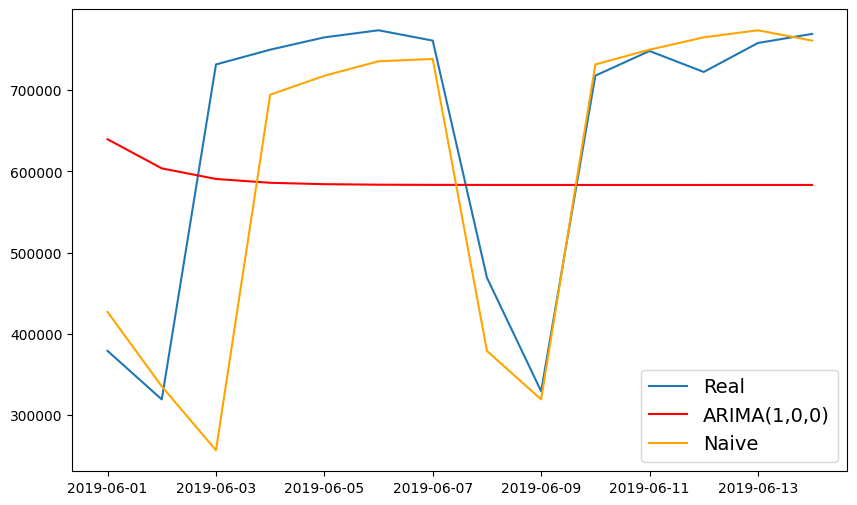

In [36]:
# dos semanas (14) días
y_pred = model.predict(14) 
y_valid = rail_series_valid.iloc[:14]

# Usando el predictor "Naive"
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"] 

plt.plot(y_valid, label = "Real")
plt.plot(y_pred, color='red', label="ARIMA(1,0,0)")
plt.plot(y_naive, color="orange", label="Naive")
plt.legend()

In [37]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 189522.89319598276
MAPE: 34.217512186979754


Fijate en el aplanamiento de la predicción y en el alto error.

Probemos con algo no tan "sencillo":

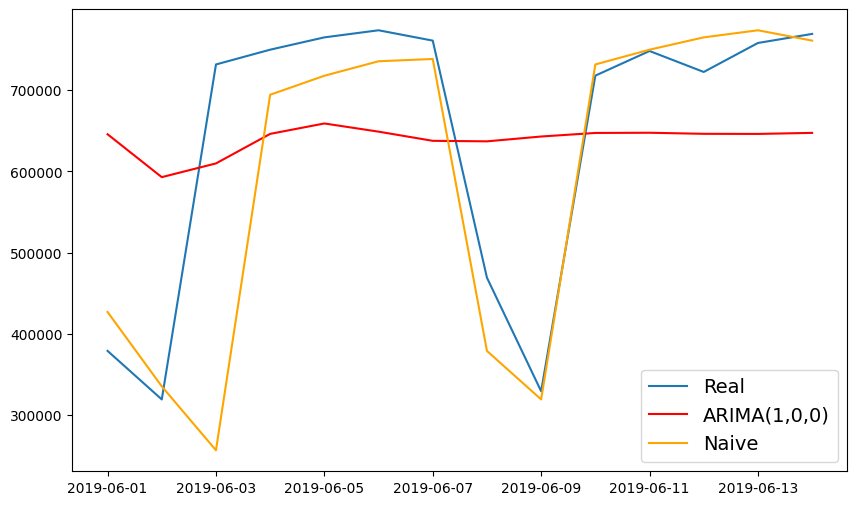

In [38]:
# (p,d,q) En realidad esto es un AR de grado 2, con un MA de grado 1 y una (d=1) diferenciación previa
model = ARIMA(order=(2, 1, 1)) 

model.fit(rail_series_train)

# dos semanas
y_pred = model.predict(14) 
y_valid = rail_series_valid.iloc[:14]

# Usando el predictor "Naive"
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"] 

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA(1,0,0)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [39]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 166513.35366481578
MAPE: 30.571802554200218


Hemos mejorado, pero así no hay manera... Evidentemente tendremos que jugar con los hiperparámetros para conseguir un mejor modelo.

***

### Búsqueda de hiperparámetros

Ahora vamos a ver una busqueda "bruta" es decir probando un grid de parámetros y comprobando cada combinación y la que mejor valor de una métrica nos dé, esa escogeremos. Esa métrica será el AIC (Akaike’s Information Criterion):

$$AIC = -2\log(L) + 2K$$

k es el número de parámetros del modelo estadístico y L es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de u conjunto de observaciones.

Se utiliza para seleccionar **el mejor modelo, que será el que tiene menor AIC**. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en terminos absolutos.


¿Por qué emplear AIC? Porque es bueno comparando modelos con varios hiperparámetros considerados a la vez, pero no sirve para el rendimiento (podríamos probar con una métrica de rendimiento). Es lo "tradicional" y será lo que te pidan saber como mínimo si trabajas con series temporales y modelos autoregresivos.

Primero generamos nuestro grid de búsqueda:

In [40]:
import itertools

p=d=q=range(0, 5)

# Obtener todas las combinaciones
pdq = list(itertools.product(p, d, q))

print("Para un rango de 0 a 4 en cada posible valor tendremos 5*5*5 combinaciones:", len(pdq))

# Solo los primeros 10 elementos 
pdq[:10] 

Para un rango de 0 a 4 en cada posible valor tendremos 5*5*5 combinaciones: 125


[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4)]

In [41]:
results = []
for param in pdq:
    try: # Por si alguna combinación "no tiene sentido" y salta un error
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(rail_series_train)
        results.append((param, model_arima_fit.aic())) # obtenemos el AIC por combinación
    except:
        results.append((param, 999999999)) # Si no tiene sentido ponemos un código especial
        continue

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

In [42]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC', ascending=True)
resultados_df.head(125)

,ARIMA params,AIC
108,"(4, 1, 3)",3967.521584
104,"(4, 0, 4)",3968.400414
109,"(4, 1, 4)",3975.863240
103,"(4, 0, 3)",3983.765015
102,"(4, 0, 2)",3992.380858
...,...,...
21,"(0, 4, 1)",4288.635828
15,"(0, 3, 0)",4290.670204
70,"(2, 4, 0)",4293.564201
45,"(1, 4, 0)",4369.454263


Como AIC no es una métrica, el consejo es probar con varios de los primeros mejores parámetros.

Probemos con esa combinación primera:

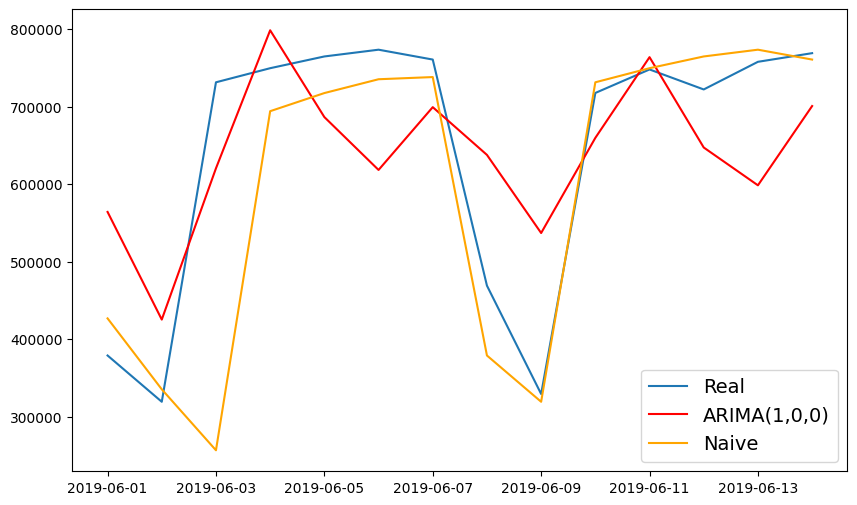

In [43]:
# p = 4, d = 1, q = 3
model = ARIMA(order=(4, 1, 3)) 

model.fit(rail_series_train)

# dos semanas
y_pred = model.predict(14) 
y_valid = rail_series_valid.iloc[:14]
# Usando el predictor "Naive"
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"] 

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA(1,0,0)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [44]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 121040.58071199617
MAPE: 20.82893515388024


Hemos mejorado mucho, pero aquí se sigue viendo la potencia de un "naive" (ojo que no siempre será así)

Como tenemos tiempo, vamos a probar con otros parámetros

RMSE: 124877.58429263147
MAPE: 15.317920065459106


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


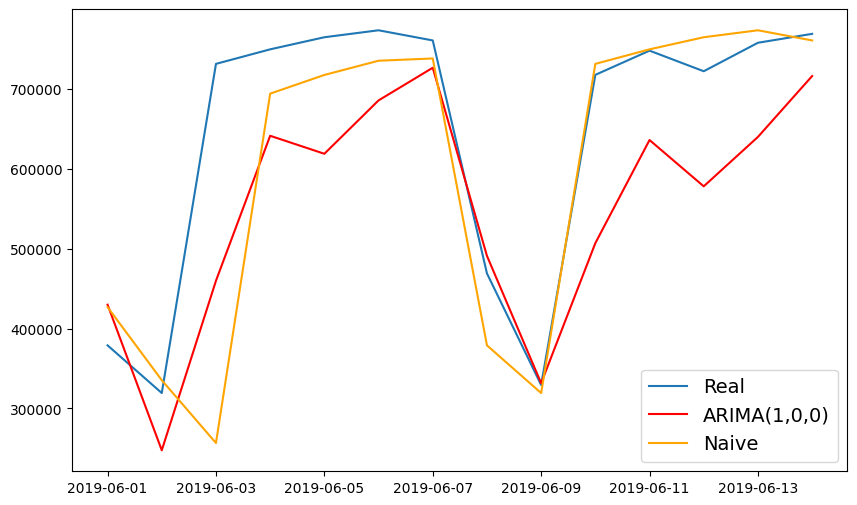

In [68]:
# p = 4, d = 1, q = 4
model = ARIMA(order=(4, 1, 4)) 

model.fit(rail_series_train)

# dos semanas
y_pred = model.predict(14) 
y_valid = rail_series_valid.iloc[:14]
# Usando el predictor "Naive"
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"] 

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA(1,0,0)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

Esta opción tiene mejor pinta. Pero sigue sin mejorar el resultado del Naive.

EL problema es que con ARIMA NO hemos quitado la componente estacional... para resolver esto llega el SARIMA.

***

### SARIMA


El siguiente miembro de la familia ARMA que veremos es el modelo ARIMA estacional (SARIMA): modela la serie temporal de la misma manera que ARIMA, pero adicionalmente modela un componente estacional para una frecuencia dada (por ejemplo, semanal), utilizando el mismo enfoque ARIMA. Tiene un total de siete hiperparámetros: los mismos hiperparámetros p, d, y q que ARIMA, más hiperparámetros P, D, y Q adicionales para modelar el patrón estacional, y finalmente el período del patrón estacional, notado como s. Los hiperparámetros P, D, y Q son justo como p, d, y q, pero se usan para modelar la serie temporal en t-s, t-2s, t-3s, etc.

Veamos cómo ajustar un modelo SARIMA a la serie temporal del ferrocarril, y usarlo para hacer un pronóstico para el pasaje de mañana. Pretenderemos que hoy es el último día de mayo de 2019, y queremos pronosticar el pasaje del ferrocarril para “mañana”, el 1 de junio de 2019.

(Sí, lo sé, la forma de usar un SARIMA es añadiendo los hiperparámetros P, D, Q y s a una clase ARIMA)

In [45]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")

# Orden: P,D,Q,s -> s=7 porque recuerda que era el periodo semanal tan pronunciado
model = ARIMA(order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7)) 

model.fit(rail_series)

# returns 427,758.6
y_pred = model.predict(1)  

In [46]:
y_pred[0], y_valid[0], y_naive[0]  # SARIMA forecast, real, y_naive

(426656.07073658897, 379044, 426932.0)

Tiene mejor pinta, comprobemos para la semana siguiente:

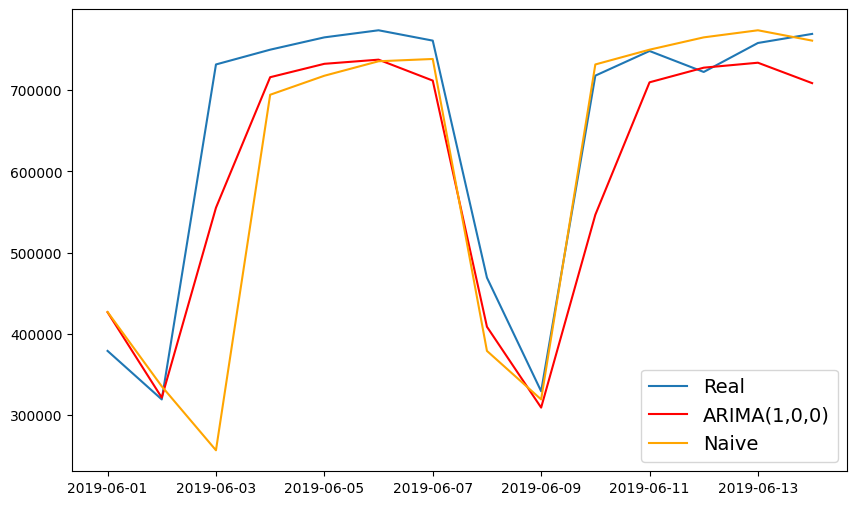

In [47]:
# dos semanas
y_pred = model.predict(14) 

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMA(1,0,0)")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [48]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 74848.87697117758
MAPE: 8.361972491779047


Mucho mejor, ¿no? Comparando con el predictor Naive:

In [49]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_naive)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_naive) * 100)

RMSE: 132507.8578276452
MAPE: 9.819873068917632


En estos 14 días de validación le hemos ganado al naive. La principal diferencia con el ARIMA tal cual, es que este con la diferenciación en general puede contrarrestar los efectos de las tendencias pero no los de la estacionalidad, un modelo que es capaz de tener en cuenta la estacionalidad mejora. Pero... vale, lo sé, el problema es que ahora tenemos 7 hiperparámetros y estos los hemos escogido porque sí... Estaría genial si alguien nos ayudase con eso más allá de probar todas las combnaciones de 7 hiperparámetros, 6 si tenemos la suerte de ver la estacionalidad tan clara como en este dataset en el que se ve que s=7 (porque son datos diarios y se "repiten" cada 7 días).

In [50]:
p=d=q=P=Q=D=range(0,5)
pdqPDQ = list(itertools.product(p,d,q,P,Q,D))
len(pdqPDQ)

15625

Una intentona por fuerza bruta similar a la que hicimos con ARIMA requiere más de 100 veces el tiempo que tardamos antes... La regla de "sabiduría popular" dice que los buenos valores de p, q, P y Q suelen ser bastante pequeños (típicamente de 0 a 2, a veces hasta 5 o 6), y d y D suelen ser principalmente 0 o 1, a veces 2. En cuanto a s, simplemente representa el periodo principal del patrón estacional: en nuestro caso es 7, ya que hay una marcada estacionalidad semanal. Eso debería permitirnos cerrar bastante los rangos. Además en vez del AIC podríamos emplear el MAE o el MAPE como criterio de selección. Por supuesto, puedes reemplazar el MAE con otra métrica si se ajusta mejor a tu objetivo comercial.

Antes de ver un modelo que se encarga de hacer ARIMA y SARIMA y también de buscar las mejores combinaciones de hiperparámetros por nosotros, vamos a añadir otras features al modelo para que haga regresiones lineales con los valores de la serie y esa feature adicional denominada exógena.

### (S)ArimaX

En esta ocasión vamos a añadir variables al modelo para ayudarle (no siempre lo conseguiremos), de forma que tanto el ARIMA como el SARIMA puedan incluir en su regresión interna esa nueva o nuevas features:

In [51]:
# Preparamos nuestras variables exogenas
bus_series_train = X_train["bus"].asfreq("D")
bus_series_valid = X_valid["bus"].asfreq("D")
mapa = { valor:X_train.loc[X_train.day_type == valor,"rail"].mean() for valor in X_train.day_type.unique()}
print(mapa)
day_series_train = X_train["day_type"].map(mapa)
day_series_valid = X_valid["day_type"].map(mapa)

{'U': 267220.8695652174, 'W': 692236.9906542056, 'A': 372482.6666666667}


In [52]:
# recuperamos los hipotéticos mejores hiperparámetros de la sección anterior
model_x = ARIMA(order=(4, 1, 3))

model_x.fit(rail_series_train, exogenous = [bus_series_train, day_series_train])
y_pred = model_x.predict(14, exogenous = [bus_series_valid, day_series_valid])

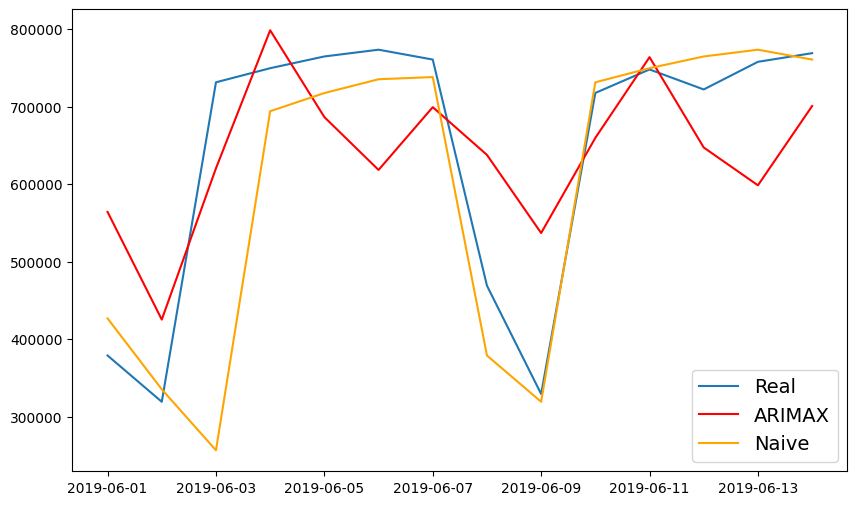

In [53]:
y_valid = rail_series_valid.iloc[:14]
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"]

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "ARIMAX")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [54]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 121040.58071199617
MAPE: 20.82893515388024


En realidad no hemos conseguido nada añadiendo las variables exógenas. Pero... Probemos en el SARIMAX:

In [55]:
# recuperamos los hipotéticos mejores hiperparámetros de la sección anterior
model_x = ARIMA(order=(1, 0, 0), seasonal_order=(0, 1, 1, 7)) 
model_x.fit(rail_series_train, exogenous = [bus_series_train, day_series_train])
y_pred = model_x.predict(14, exogenous = [bus_series_valid, day_series_valid])

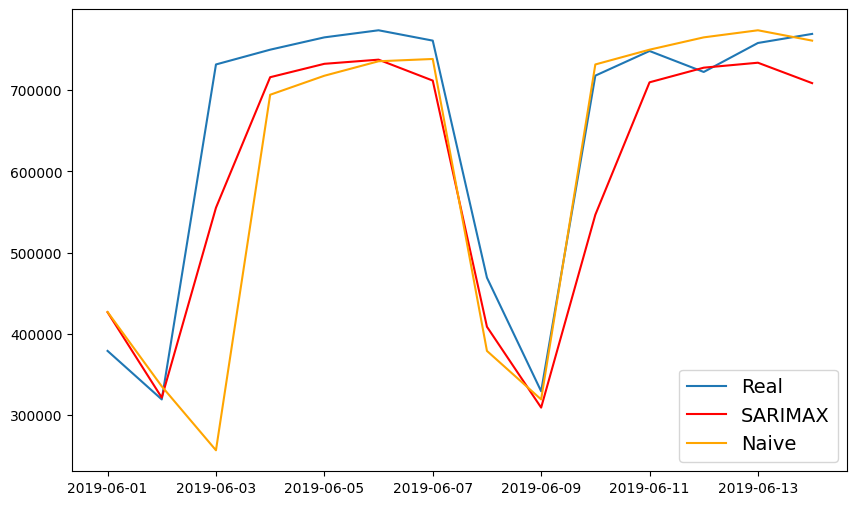

In [56]:
y_valid = rail_series_valid.iloc[:14]
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"] 

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "SARIMAX")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [57]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 74848.87697117758
MAPE: 8.361972491779047


No ha cambiado nada. Te lo dejo ahí por si alguna vez quieres probar. 

***

### Auto ARIMA

Para terminar vamos a ver una implementación de ARIMA que incluye la selección de los hiperparáemtros y que tiene también una forma de activar que use un SARIMA.

#### auto ARIMA (sin estacionalidad)

Tenemos un modelo en la librería pdarima, que ya hace una prueba de hiperparámetros internamente, con dos modalidades:

1. Tipo eurítstico (no prueba todas las combinaciones)

In [58]:
from pmdarima.arima import auto_arima

model = auto_arima(rail_series_train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   trace=True,
                   stepwise=True) # Está a True por defecto


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4109.158, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4111.044, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4110.082, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4107.197, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds


En model ya tenemos el mejor modelo que ha encontrado:

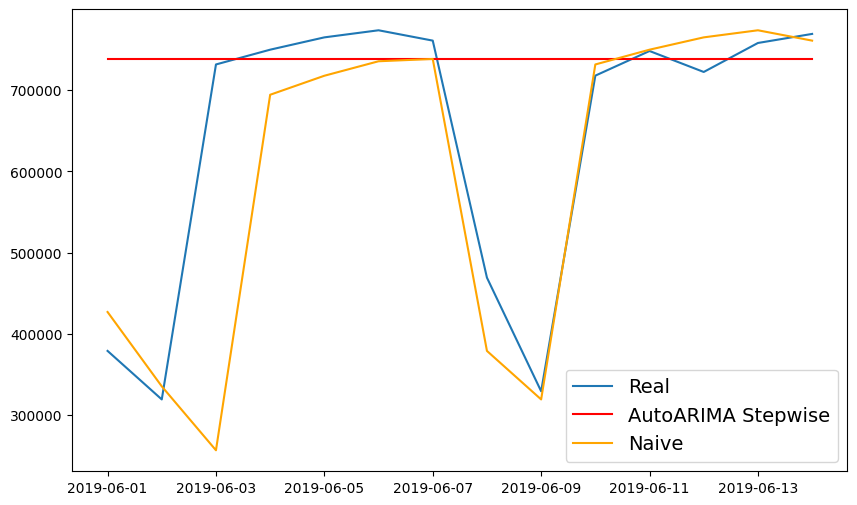

In [59]:
y_pred = model.predict(14)
y_valid = rail_series_valid.iloc[:14]
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"]

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "AutoARIMA Stepwise")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [60]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 198033.73483612045
MAPE: 30.996373295550157


Salio malo, aunque mejor que nuestro primer ARIMA :-)

2. Mediante una búsqueda "completa" (ojo "d" se estima mediante una serie de test internos y se escoge d = min(max_d, d escogido internamente) y sigue otros criterios de reducción de combinaciones):

In [61]:
model = auto_arima(rail_series_train,
                   start_p = 0,
                   start_q = 0,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   trace= True,
                   stepwise = False) # Hay que desactivar este parámetro


 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=4109.158, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=4110.082, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=4037.353, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=4047.717, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=4042.329, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=4040.856, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=4111.044, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=4041.384, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=4041.097, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=4043.612, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=4077.923, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=4036.332, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=4024.717, Time=0.57 sec
 ARIMA(3,1,0)(0,0,0)

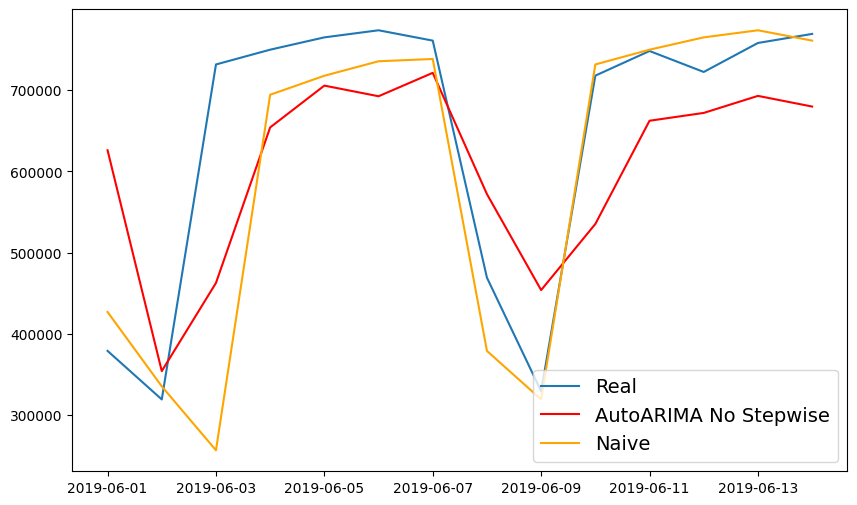

In [62]:
y_pred = model.predict(14)
y_valid = rail_series_valid.iloc[:14]
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"]

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "AutoARIMA No Stepwise")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [63]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 130063.30530483078
MAPE: 19.48833630824573


Mejor sin duda. Pero lo bueno viene ahora, se puede aplicar al SARIMA.

### Auto SARIMA:

In [64]:
model = auto_arima(rail_series_train,
                   start_p=0,
                   start_q=0,
                   max_p=5,
                   max_q=5,
                   max_d=3,
                   m=7,
                   trace=True,
                   stepwise=False)

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4109.158, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=4054.277, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=4039.660, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=4019.697, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4010.316, Time=0.05 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=4011.950, Time=0.08 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=4013.848, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=4011.860, Time=0.13 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4110.082, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4056.192, Time=0.06 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4041.576, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=4020.864, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4010.384, Time=0.08 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4012.172, Time=0.17 sec
 ARIMA(0,1,1)(2

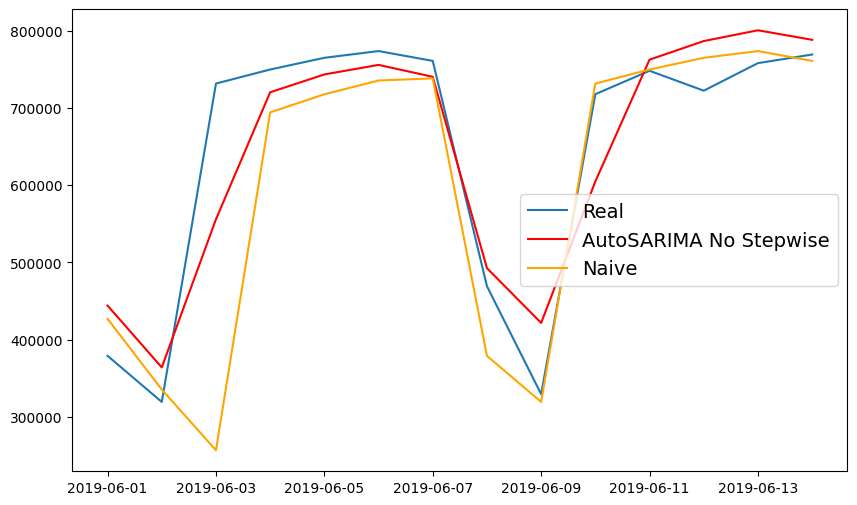

In [65]:
y_pred = model.predict(14)
y_valid = rail_series_valid.iloc[:14]
y_naive = df.loc["2019-05":"2019-06","rail"].shift(7).loc["2019-06-01":"2019-06-14"]

plt.plot(y_valid, label = "Real")
plt.plot(y_pred,color='red', label = "AutoSARIMA No Stepwise")
plt.plot(y_naive, color = "orange", label ="Naive")
plt.legend()

In [66]:
print("RMSE:", np.sqrt(mean_squared_error(y_valid, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_valid, y_pred) * 100)

RMSE: 69446.09402029167
MAPE: 9.613556003269506


Mucho mejor que los anteriores, pero no mejora al naive, y una selección más sencilla como la que probamos por primera vez salió mejor. 

$$*$$

### Series Temporales: Breve guía orientativa

0. Entender el problema de negocio: En este sentido la predicción de series temporales parece algo más sencillo, pero siempre debemos tener claro que métrica (MAPE es muy interesante, pero puede que haya otras), qué rangos son aceptables, etc. Además de entender el problema de negocio pueden surgir pistas sobre la estacionalidad, tendencia, factores exógenos,etc.

1. Preparación de los datos

- **Cargar los datos**: Importa tus datos en un DataFrame de Pandas. Asegúrate de que la serie temporal esté en formato de fecha y hora (`datetime`) y esté configurada como el índice del DataFrame.


2. Train/Valid/Test split

- **Haz el split por fechas**, quedándote con las últimas para el test, las anteriores para la validación y el resto para un primer train. Importante: Cuidado con los periodos y la estacionalidad, por ejemplo tienes datos anuales y resulta que son ventas y los últimos datos son los de Navidad... Quizás quieras mover la ventana hacia atrás o esperar a tener más datos para que la variación por "estación" no te afecte tanto.

3. MinEDA:
  
- **Visualización de los datos**: Haz una gráfica de tu serie temporal para obtener una comprensión visual de los datos, incluyendo tendencias, estacionalidad y cualquier otro patrón observable.

- **Verificar estacionariedad**: La mayoría de los modelos ARIMA/SARIMA requieren que la serie temporal sea estacionaria. Utiliza el test de Dickey-Fuller Aumentado para verificar la estacionariedad y el análisis de los componentes obteniéndolos tanto para una aproximación aditiva como para una aproximación multiplicativa. En este momento hay que intentar capturar la estacionalidad.

- **Diferenciación**: Si la serie no es estacionaria, está claro que necesitarás diferenciar. En los modelos el hiperparámetro d no debe ser cero. Si además viste la estacionalidad en el apartado anterior ya deberías tener una idea del valor de s/m a probar en los modelos.

4. Modelado Inicial:

- **AutoARIMA**: Lanza un auto_arima, si puedes con stepwise = False, y observa los valores obtenidos. Esto debería darte una idea del rango de valores a probar por tu cuenta. Prepara un grid de p,d,q y si hace falta de P,D,Q. Testea los valores del auto_arima contra el test de validación y así tendrás una idea para comparar con tu ajuste fino personal.

5. Ajuste fino:

- **Busqueda manual**: Sobre los valores obtenidos en el apartado anterior haz un búsqueda corta manual. Pero testea contra la métrica (MAE, MAPE, etc) no contra el AIC. Quédate con los mejore valores.
- **Analiza gráficamente la validación**

6. Evaluación:

- **Entrena el modelo incluyendo el dataset de train y el de validación**: Evalua numérica y gráficamente el modelo.


